# Dogs life expectancy predictors
Data from Wallis LJ, Szabó D, Erdélyi-Belle B, Kubinyi E. Demographic Change Across the Lifespan of Pet Dogs and Their Impact on Health Status. Front Vet Sci. 2018 Aug 23;5:200. doi: 10.3389/fvets.2018.00200. PMID: 30191153; PMCID: PMC6115627.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Packages for Logistic Regression & Confusion Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [41]:
def histogrammer(df, column_str, median_text=True, **kwargs):    # **kwargs = any keyword arguments
    """
    Plots a histogram of a given column of a dataframe with a vertical line at the median.

    Args:
        df (pd.DataFrame): The dataframe containing the column to plot.
        column_str (str): The name of the column to plot.
        median_text (bool): Whether to display the median value on the plot.
        **kwargs: Additional keyword arguments for the histogram.
    """              
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df[column_str], **kwargs)            # Plot the histogram
    plt.axvline(median, color='red', linestyle='--')         # Plot the median line
    if median_text==True:                                    # Add median text unless set to False
        ax.text(0.75, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram')
    plt.show()

In [42]:
def outlier_imputer(df, column_name, percentile):
    """
    Impute outliers in a given column of a dataframe with the threshold value.

    Args:
        df (pd.DataFrame): The dataframe containing the column to impute.
        column_name (str): The name of the column to impute.
        percentile (float): The percentile to use as the threshold.

    Returns:
        pd.DataFrame: The dataframe with the imputed outliers.
    """
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)

    if np.any(df[column_name] > threshold):
        count = np.sum(df[column_name] > threshold)
        percentage = (count/len(df))*100

        print(f'{column_name} : {count} outliers imputed, representing {round(percentage, 4)}%')

        # Impute threshold for values > than threshold
        df.loc[df[column_name] > threshold, column_name] = threshold
    
    return df

#### Load dataset

In [43]:
df = pd.read_excel('Data_Sheet_1_Demographic_Change_Across_the_Lifespan_of_Pet_Dogs_and_Their_Impact_on_Health_Status.XLSX', sheet_name='QUESTIONNAIRE')

## Exploratory Data Analysis

In [44]:
df.head()

,id,Health_status,Sex,Age_in_months,Age_group,Height,Weight,Breed,Neuter_status,Sensory_problems,...,Life_event_mating_pregnancy,Life_event_change_in_family_structure,Life_event_No_dogs_household_changed,Life_event_moved_house,Life_event_changed_owners,Life_event_spent_more_time_alone,Life_event_lost,Life_event_injury_surgery,Life_event_spent_time_at_shelter,Life_events
0,dog2,0,2,139,5,43,9,2,1,0,...,0,0,1,0,0,0,0,1,0,1
1,dog3,1,2,128,5,50,15,1,1,0,...,1,0,0,0,0,0,0,0,0,0
2,dog4,0,2,111,4,53,35,1,2,0,...,0,1,1,1,0,1,0,0,0,2
3,dog5,0,2,164,6,55,20,1,1,0,...,1,1,1,0,0,0,0,0,0,1
4,dog6,0,2,147,6,46,14,2,2,0,...,1,1,1,0,0,1,0,0,0,2


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     1207 non-null   object
 1   Health_status                          1207 non-null   int64 
 2   Sex                                    1207 non-null   int64 
 3   Age_in_months                          1207 non-null   int64 
 4   Age_group                              1207 non-null   int64 
 5   Height                                 1207 non-null   int64 
 6   Weight                                 1207 non-null   int64 
 7   Breed                                  1207 non-null   int64 
 8   Neuter_status                          1207 non-null   int64 
 9   Sensory_problems                       1207 non-null   int64 
 10  Offleash_activity                      1207 non-null   int64 
 11  Body_condition_sc

All variables are of type int64 except for the id which is of type object. 

There are no missing data. 

In [46]:
# Explore possible values for each column
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'id': ['dog2' 'dog3' 'dog4' ... 'dog1372' 'dog1373' 'dog1374']
Unique values in column 'Health_status': [0 1]
Unique values in column 'Sex': [2 1]
Unique values in column 'Age_in_months': [139 128 111 164 147 102  99 122  69 151  97 138  42  63  41  56 133  67
  59 132 127 124  96 153 172 115 159 204 109  84 145 134  92 218  77  26
 170  52 121  25  49  16 106  27  43  94  79  48 180  72  85  45  73 154
 117 125  78 162 110 123  46 130 126 188  37  61  89 152 114  80  90 119
 131  75 101 193 186  57  21  93 120 108 189 144  86  35  82  38  12 192
  39  81  31  40  51  17 158  98  71  14  65  29 169  54  18  60 182  88
  62 129 107 196 163  24  20  33 198  28  30 173  36  34  50 116 181  68
  55 100  76  87 137  64 168  47  32 176 148  15  13 113 141 146 136 103
 112 165  66 157  44 194 199  95 104  22 105 135 206 155 156  70 150  83
 185 161  91  53 149 143 171 178  19 140 197 316  23 210  58  74 166 183
 142 118 208 253 265 160 190 167 179 216 214]
Unique value

Remove redundant columns: 
- Information in Age_group is included in Age_in_months
- All the life events are included in Life_events
- Health problems and Sensory problems : were used to code healthy vs unhealthy dogs 
- Medication and Dog_beh_changed_3month : probably reflect health problems, not predictors.

In [47]:
df = df.drop(columns = ['id','Age_group', 'Life_event_mating_pregnancy', 'Life_event_change_in_family_structure',
                        'Life_event_No_dogs_household_changed', 'Life_event_moved_house',
                        'Life_event_changed_owners', 'Life_event_spent_more_time_alone',
                        'Life_event_lost', 'Life_event_injury_surgery', 'Life_event_spent_time_at_shelter', 
                        'Health_problems', 'Sensory_problems', 'Medication', 'Dog_beh_changed_3month'])

In [48]:
# Variables categorization
categorical_var = ['Sex', 'Breed', 'Neuter_status', 'Trauma', 'Owner_gender', 
                   'Child', 'get_dog', 'Food', 'Where_dog_is_kept']
continuous_var = ['Age_in_months', 'Height', 'Weight']
ordinal_var = ['Offleash_activity', 'Body_condition_score', 'Vitamins', 
               'Owner_age', 'Owner_experience', 'Other_dogs_in_house', 
               'People_in_household', 'Age_of_dog_when_arrived', 
               'Dog_obedience_tasks', 'Play', 'Commands', 'Dog_training_activities', 
               'Time_dog_spend_alone', 'Life_events']

Variables recoding

In [49]:
# some binary variables are coded 1-2 instead of 0-1, so correct it
for col in df.columns:
    if set(df[col].unique()) == {1, 2}:
        df[col] = df[col].replace({1: 0, 2: 1})

# Body_condition_score will be recoded from smaller to bigger into an ordinal variable
df['Body_condition_score'] = df['Body_condition_score'].replace({2: 3, 3: 2})

# Recode Health_status: Healthy = 0, Unhealthy = 1 by reversing the current encoding (0->1, 1->0)
df['Health_status'] = df['Health_status'].replace({0: 1, 1: 0})

In [50]:
# Verify dependent variable class balance
df['Health_status'].value_counts(normalize=True)

Health_status
1    0.605634
0    0.394366
Name: proportion, dtype: float64

More unhealthy than healthy dogs, but the class imbalance is not too important so continue analyses. 

#### Features inspection and creation

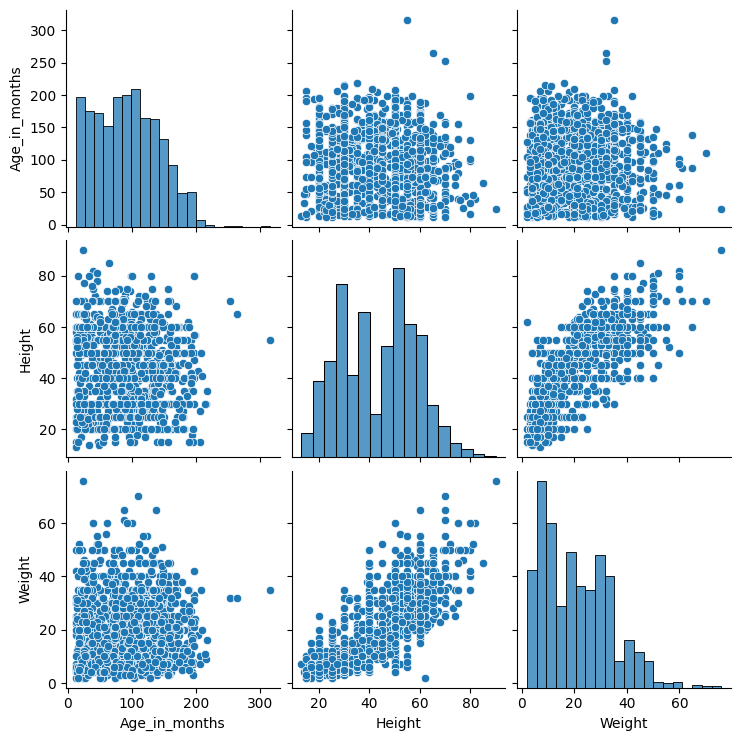

In [51]:
sns.pairplot(df[continuous_var])
plt.show()

Height and weight are correlated, so a new feature for their ratio weight/height is created.

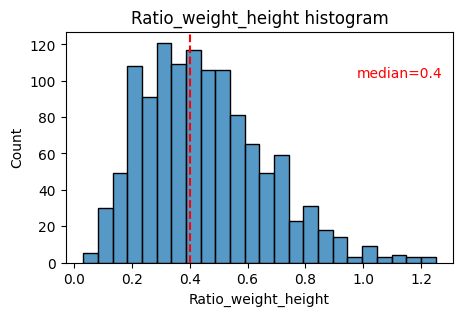

count    1207.000000
mean        0.451560
std         0.209475
min         0.032258
25%         0.300000
50%         0.428571
75%         0.581607
max         1.250000
Name: Ratio_weight_height, dtype: float64

In [52]:
df['Ratio_weight_height'] = df['Weight']/df['Height']
df = df.drop(columns = ['Weight', 'Height']) # update dataframe
continuous_var = list(set(continuous_var) - set(['Weight', 'Height'])) +  ['Ratio_weight_height'] # update continuous variables list

histogrammer(df, 'Ratio_weight_height')

df['Ratio_weight_height'].describe()

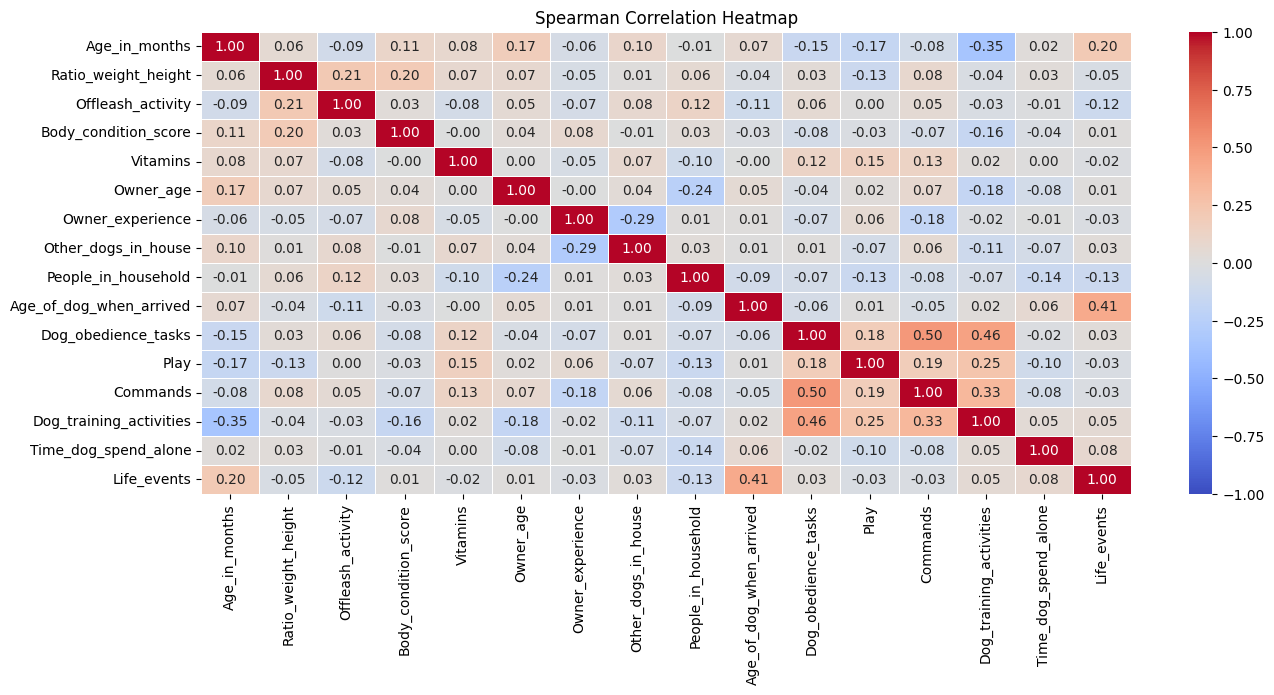

In [53]:
# spearman correlation to explore correlation between non categorical variables
corr = df[continuous_var + ordinal_var].corr(method='spearman')

plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

Dog_obedience_tasks, Commands, Dog_training_activities are correlated and represent similar information. They are combined into a new feature. 

In [54]:
# Z score per variable to get same scales and average  
scaler = StandardScaler()
X = scaler.fit_transform(df[["Dog_obedience_tasks", "Commands", "Dog_training_activities"]])

df['Training_level'] = X.mean(axis=1)


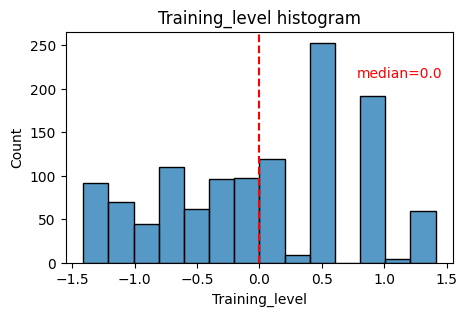

In [55]:
histogrammer(df, 'Training_level')

The variables previously combined into features and Body_condition_score because it is redundant with ratio_weight_height are removed. 

In [56]:
df = df.drop(columns = ["Dog_obedience_tasks", "Commands", "Dog_training_activities", "Body_condition_score"]) # update dataframe
# add Training_level to ordinal_var and variables combined 
ordinal_var = list(set(ordinal_var) - set(["Dog_obedience_tasks", "Commands", "Dog_training_activities", "Body_condition_score"]) | set(['Training_level'])) # update ordinal variables list 

#### Check for outliers in continuous variables
Values are considered outliers when > than 95th percentile and replaced with this value. 

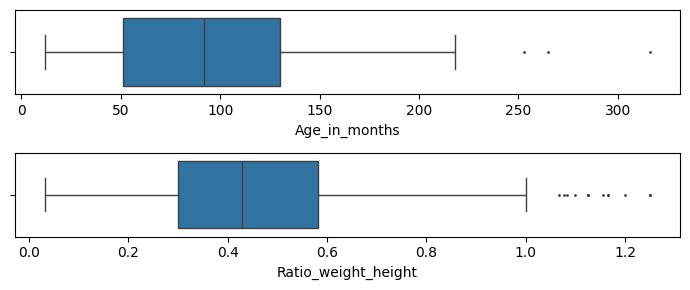

In [57]:
fig, axes = plt.subplots(len(continuous_var), 1, figsize=(7, 3))

for i in range(len(continuous_var)):
    sns.boxplot(x=df[continuous_var[i]], fliersize=1, ax=axes[i])

plt.tight_layout()
plt.show()

In [58]:
percentile = 0.95 # percentile after which value is considered outlier and imputed

for var in continuous_var:
    outlier_imputer(df, var, percentile)

Age_in_months : 60 outliers imputed, representing 4.971%
Ratio_weight_height : 58 outliers imputed, representing 4.8053%


Under 5% of outliers, so considered ok. 

## Logistic regression

### Assumptions
* Independent observations : we assume independance of observations 

* No extreme outliers : outliers identified and imputed, less than 5% for continuous variables

* Little to no multicollinearity among X predictors

* Linear relationship between continuous X predictors and the **logit** of y : will be verified after modeling

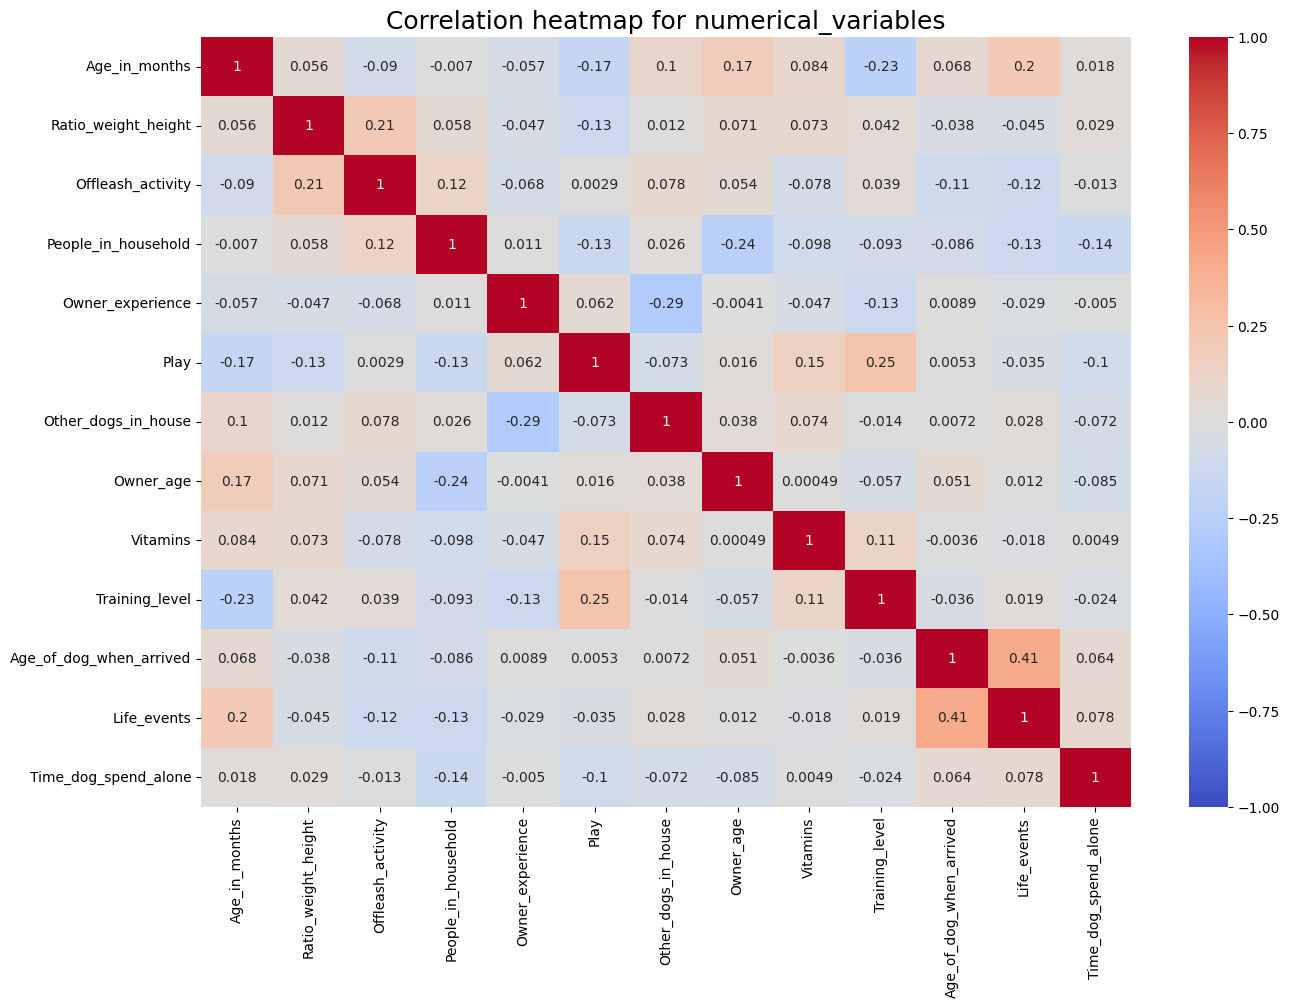

In [59]:
# Check for multicollinearity (using spearman correlation for ordinal variables)
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df[continuous_var+ordinal_var].corr(method='spearman'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap for numerical_variables',
          fontsize=18)
plt.show();

No correlation higher than chosen 0.6 threshold, so multicolinerity respected. 

### Model
Predictors : sex, breed, food, owner gender, owner age, ratio weight height, training level, life events

Dogs age is not included in the analysis even if it is probably a good predictor, as it would dominate the model without offering actionable insights. 

In [60]:
X = df[['Sex', 'Breed', 'Food', 'Owner_age', 'Life_events', 'Ratio_weight_height', 'Training_level']]
y = df['Health_status']

Ordinal variables : 
- Owner age will be treated as a categorical variable because the difference between levels may not be the same/linear. Treating it as numerical could lose information
- Life events will be treated as numerical because the levels represent roughly the amount of life events
- Food is a categorical variable 

In [61]:
# One-hot encode categorical variables with more than 2 categories
# One-hot encode ordinal variables otherwise difference between levels will be considered the same 
X_encoded = pd.get_dummies(
    X,
    columns=["Food", "Owner_age"],
    drop_first=True
)

In [62]:
X_encoded.head()

,Sex,Breed,Life_events,Ratio_weight_height,Training_level,Food_2,Food_3,Food_4,Food_5,Owner_age_2,Owner_age_3,Owner_age_4
0,1,1,1,0.209302,-1.102109,False,False,True,False,False,True,False
1,1,0,0,0.300000,-0.346599,False,False,True,False,False,False,True
2,1,0,2,0.660377,0.099706,False,False,False,False,False,False,False
3,1,0,1,0.363636,-0.463907,False,False,False,False,True,False,False
4,1,1,2,0.304348,0.017405,False,False,False,True,False,True,False


In [63]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

model = LogisticRegression(max_iter=400)

model.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [64]:
# Model Coefficients (Log-Odds)
coefs= pd.Series(model.coef_[0], index=X_encoded.columns)
intercept = model.intercept_[0]
coefs, intercept


(Sex                   -0.206511
 Breed                  0.182290
 Life_events            0.264184
 Ratio_weight_height    0.154488
 Training_level        -0.239578
 Food_2                -0.411628
 Food_3                -0.092561
 Food_4                -0.401957
 Food_5                -0.716964
 Owner_age_2            0.227611
 Owner_age_3            0.134213
 Owner_age_4           -0.048085
 dtype: float64,
 np.float64(0.19592591461265754))

#### Verify linear relationship between logit and predictors

In [65]:
# Verify linear relationship between logit and continuous predictors (Ratio_weight_height, Training_level, life_events)
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)

# Copy the X_train dataframe and assign to logit_data
logit_data = X_train[["Ratio_weight_height", "Training_level", "Life_events"]].copy()

# Create a new logit column in the logit_data df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

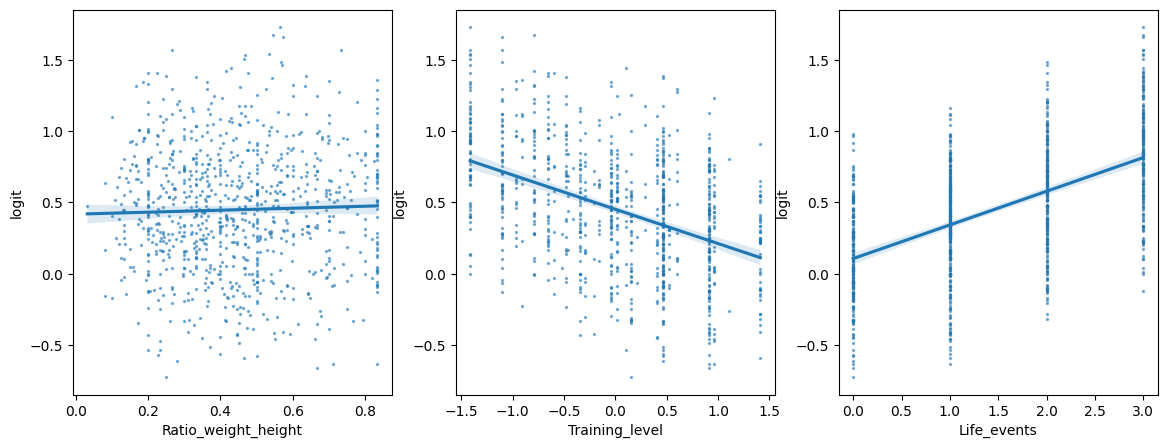

In [66]:
# plot logit of y vs each continuous predictor
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for i in range(len(logit_data.columns) - 1):
    sns.regplot(x=logit_data.columns[i], y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5}, ax = axes[i])

plt.show()

Linearity considered respected

### Results and evaluation

In [67]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

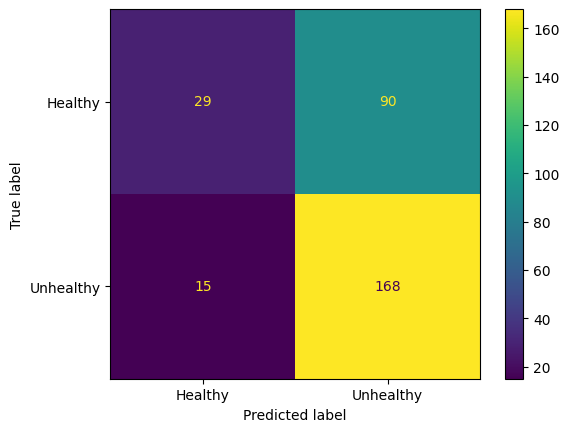

In [68]:
cm = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Healthy', 'Unhealthy'],
                              )
disp.plot()
plt.show()

In [69]:
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_preds, target_names=['Healthy', 'Unhealthy']))
print("\n" + "=" * 60)
print("DETAILED METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy_score(y_test, y_preds):.4f}")
print(f"Precision: {precision_score(y_test, y_preds):.4f}")
print(f"Recall:    {recall_score(y_test, y_preds):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_preds):.4f}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy       0.66      0.24      0.36       119
   Unhealthy       0.65      0.92      0.76       183

    accuracy                           0.65       302
   macro avg       0.66      0.58      0.56       302
weighted avg       0.65      0.65      0.60       302


DETAILED METRICS
Accuracy:  0.6523
Precision: 0.6512
Recall:    0.9180
F1-Score:  0.7619


Observations :
- 65% of data were correctly identified
- 65% of dogs identified as Unhealthy were truly Unhealthy
- 92% of the Unhealthy dogs were correctly identified

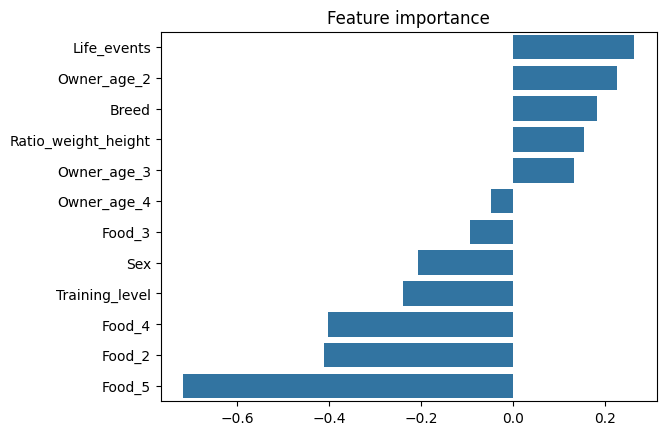

In [70]:
# Feature importance
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

In [71]:
# Calculate Odds Ratios (more interpretable than coefficients)
odds_ratios = np.exp(coefs)

# Create a summary dataframe
predictor_summary = pd.DataFrame({
    'Coefficient': coefs,
    'Odds_Ratio': odds_ratios,
    'Abs_Coefficient': np.abs(coefs),
    'perc_comparison': (odds_ratios-1)*100
})

# Sort by absolute coefficient (importance)
predictor_summary = predictor_summary.sort_values('Abs_Coefficient', ascending=False)

print("=" * 50)
print("PREDICTOR IMPORTANCE SUMMARY")
print("=" * 50)
print(predictor_summary[['Coefficient', 'Odds_Ratio', 'perc_comparison']].to_string())

PREDICTOR IMPORTANCE SUMMARY
                     Coefficient  Odds_Ratio  perc_comparison
Food_5                 -0.716964    0.488232       -51.176776
Food_2                 -0.411628    0.662571       -33.742943
Food_4                 -0.401957    0.669009       -33.099072
Life_events             0.264184    1.302368        30.236794
Training_level         -0.239578    0.786960       -21.304026
Owner_age_2             0.227611    1.255597        25.559664
Sex                    -0.206511    0.813418       -18.658240
Breed                   0.182290    1.199962        19.996187
Ratio_weight_height     0.154488    1.167060        16.706018
Owner_age_3             0.134213    1.143636        14.363590
Food_3                 -0.092561    0.911594        -8.840626
Owner_age_4            -0.048085    0.953053        -4.694740


Food:
- Eating only raw food is associated with around 51% less chance of being unhealthy compared to eating only dry food, with all other variables maintained constant. 
- Eating tinned and dry food is associated with around 34% less chance of being unhealthy compared to eating only dry food, with all other variables maintained constant. 
- Eating mixed food is associated with around 33% less chance of being unhealthy compared to eating only dry food, with all other variables maintained constant. 
- Eating cooked food is associated with around 9% less chance of being unhealthy compared to eating only dry food, with all other variables maintained constant. 

Recommandation: Feeding regimes other than dry food only, particularly raw and mixed diets, were associated with lower odds of poor health. A good choice for dog owners can be to feed their dog tinned and dry food, which is associated with lower health risk at a much lower cost than feeding them only raw food. However, food choice is likely related to other factors like owner engagement, socioeconomic background, etc. 

Training : 
- An increase in one unit of training level is associated with 21% lower odds of being unhealthy, with all other variables maintained constant. 

Recommandation: More training seems to be associated with better health outcome. 

Owner: 
- Having an owner between 30 and 39 years is associated with around 26% higher odds of being unhealthy than having an owner younger than 29 years old, with all other variables maintained constant. 
- Having an owner between 40 and 49 years is associated with around 14% higher odds of being unhealthy than having an owner younger than 29 years old, with all other variables maintained constant. 
- Having an owner older than 50 years old is associated with around 5% higher odds of being unhealthy than having an owner younger than 29 years old, with all other variables maintained constant. 
-> An explanation could be that between 30-39 years old, most people work hard on their career, start having kids, etc, giving them less time to take care of their dog, which could be associated to poorer health. 

Dog:
- Female dogs are associated with around 19% lower odds of being unhealthy than male dogs, with all other variables maintained constant. 
- Pure breed are associated with around 20% higher odds of being unhealthy than mixed dogs, with all other variables maintained constant. 
- An increase in one unit of ratio weight/height is associated with around 17% higher odds of being unhealthy, with all other variables maintained constant. 
- An increase in one unit of life events is associated with around 30% higher odds of being unhealthy, with all other variables maintained constant. 